# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></div><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset</a></div><div class="lev1 toc-item"><a href="#Custom-components" data-toc-modified-id="Custom-components-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Custom components</a></div><div class="lev2 toc-item"><a href="#Definition" data-toc-modified-id="Definition-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Definition</a></div><div class="lev2 toc-item"><a href="#Behavior" data-toc-modified-id="Behavior-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Behavior</a></div><div class="lev1 toc-item"><a href="#Usage" data-toc-modified-id="Usage-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Usage</a></div><div class="lev1 toc-item"><a href="#Feature-importances" data-toc-modified-id="Feature-importances-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature importances</a></div><div class="lev2 toc-item"><a href="#Handmade" data-toc-modified-id="Handmade-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Handmade</a></div><div class="lev2 toc-item"><a href="#Using-ELI5" data-toc-modified-id="Using-ELI5-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Using ELI5</a></div><div class="lev1 toc-item"><a href="#Explain-a-single-prediction" data-toc-modified-id="Explain-a-single-prediction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Explain a single prediction</a></div>

# Description

TODO

# Imports

In [1]:
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

import eli5

%matplotlib inline

# Dataset

In [2]:
train_df = pd.DataFrame([
    ['cool orange car',               'CAR'],
    ['cool white car',                'CAR'],
    ['cool green truck (very cool!)', 'TRUCK'],
    ['cool red truck',                'TRUCK'],
], columns=['text', 'label'])
train_df

,text,label
0,cool orange car,CAR
1,cool white car,CAR
2,cool green truck (very cool!),TRUCK
3,cool red truck,TRUCK


# Custom components

## Definition

In [3]:
class FeaturePipeline(Pipeline):
    
    def get_feature_names(self):
        name, trans = self.steps[-1]
        if not hasattr(trans, 'get_feature_names'):
            raise AttributeError('Transformer %s (type %s) does not '
                                 'provide get_feature_names.' % (str(name), type(trans).__name__))
        return trans.get_feature_names()

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.column]
        elif isinstance(X, pd.Series):
            return pd.Series([X[self.column]], name=self.column)
        else:
            raise ValueError('Hey! Give me either a DataFrame (table) or a Series (row)!')
    
    def get_feature_names(self):
        return [self.column]

## Behavior

In [5]:
ColumnSelector('text').transform(train_df)

0                  cool orange car
1                   cool white car
2    cool green truck (very cool!)
3                   cool red truck
Name: text, dtype: object

In [6]:
ColumnSelector('text').transform(train_df.iloc[0])

0    cool orange car
Name: text, dtype: object

# Usage

In [7]:
model = Pipeline([
    ('vec', FeatureUnion([

        ('text_tfidf', FeaturePipeline([
            ('sel', ColumnSelector('text')),
            ('vec', TfidfVectorizer(min_df=2))
        ])),

        ('text_count', FeaturePipeline([
            ('sel', ColumnSelector('text')),
            ('vec', CountVectorizer(min_df=3))
        ]))

    ])),
    ('clf', LogisticRegression())
])

In [8]:
model.fit(train_df, train_df.label)

Pipeline(memory=None,
     steps=[('vec', FeatureUnion(n_jobs=1,
       transformer_list=[('text_tfidf', FeaturePipeline(memory=None,
        steps=[('sel', ColumnSelector(column='text')), ('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', inp...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [9]:
model.named_steps.vec.get_feature_names()

[u'text_tfidf__car',
 u'text_tfidf__cool',
 u'text_tfidf__truck',
 u'text_count__cool']

In [10]:
model.named_steps.vec.transform(train_df).todense()

matrix([[ 0.83388421,  0.55193942,  0.        ,  1.        ],
        [ 0.83388421,  0.55193942,  0.        ,  1.        ],
        [ 0.        ,  0.7979221 ,  0.60276058,  2.        ],
        [ 0.        ,  0.55193942,  0.83388421,  1.        ]])

In [11]:
model.predict(train_df)

array(['CAR', 'CAR', 'TRUCK', 'TRUCK'], dtype=object)

In [12]:
model.predict(train_df.iloc[0])

array(['CAR'], dtype=object)

# Feature importances

## Handmade

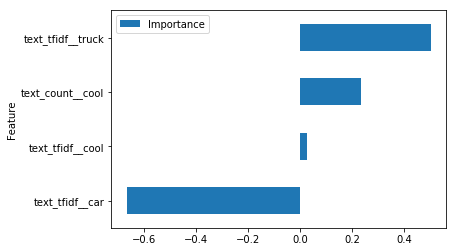

In [13]:
pd.DataFrame.from_dict({
    'Feature': model.named_steps.vec.get_feature_names(),
    'Importance': model.named_steps.clf.coef_.ravel(),
}).sort_values('Importance').set_index('Feature').plot.barh()

## Using ELI5

In [14]:
eli5.show_weights(model)

Weight?,Feature
+0.504,text_tfidf:truck
+0.233,text_count:cool
+0.026,text_tfidf:cool
-0.102,<BIAS>
-0.666,text_tfidf:car


# Explain a single prediction

In [15]:
eli5.show_prediction(
    model.named_steps.clf,
    feature_names=model.named_steps.vec.get_feature_names(),
    doc=model.named_steps.vec.transform(train_df.iloc[0])
)